### Importing all the necessary Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from IPython import display
import PIL
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Setting Up the GPU for better performance

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# Allocate a tensor on the GPU
with tf.device('/GPU:0'):
    tensor = tf.random.normal((2, 2))

print(tensor.device)

/job:localhost/replica:0/task:0/device:GPU:0


### Importing the dataset

In [7]:
dataset_dir = 'data/portraitdataset/'

In [8]:
datagen = ImageDataGenerator(rescale=1./255)

In [10]:
target_size = (128, 128)

batch_size = 16

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',  
    subset='training'
)

Found 14965 images belonging to 1 classes.


The data generator here is used for loading images from a directory in preparation for training a machine learning model. The flow_from_directory function from the Keras ImageDataGenerator class is used for this purpose. Firstly, the dataset_dir variable specifies the path to the directory containing the dataset. Images from this directory will be loaded for training.

Next, the target_size parameter is set to (128, 128), indicating that the images will be resized to a resolution of 128x128 pixels during loading. This standardizes the input dimensions for the model.

The batch_size variable is set to 16, determining the number of images that will be loaded and processed together as a batch during each training iteration. Adjusting the batch size can impact training speed and memory usage.

The class_mode parameter is set to 'binary', indicating that the data consists of two classes (e.g., positive and negative, or class 0 and class 1). This is suitable for binary classification tasks.

Lastly, the subset parameter is set to 'training', specifying that only a subset of the data (specifically, the training subset) will be loaded. This is useful when working with a larger dataset and separating it into distinct subsets for training, validation, and testing.

#### Plotting some images from our data

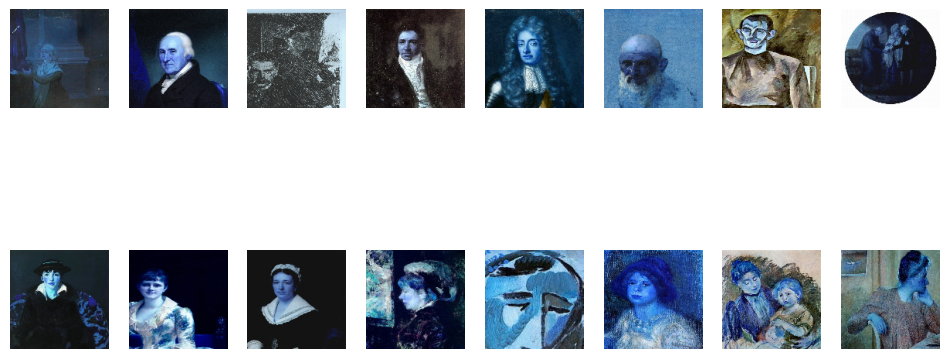

In [11]:
# Define a function to plot images
def plot_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(12, 12))
    for i in range(len(images)):
        plt.subplot(4, 8, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

# Plot training images
plot_images(train_generator)

the plot_images(generator) is used here to visualize a batch of images generated by the given generator. It retrieves the next batch of images and labels, plots them in a 4x8 grid layout, and displays the plot using Matplotlib.

#### Preprocessing the data

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16
IMAGE_SIZE = [112, 112]

AUTOTUNE is a TensorFlow constant used for optimizing data loading by automatically adjusting the number of parallel threads.

BATCH_SIZE specifies the number of images processed together in each training iteration.

IMAGE_SIZE defines the desired dimensions (width and height) to which images will be resized during preprocessing, ensuring uniformity for model input.

In [14]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [15]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [-1,1] range.
  img = normalize(img)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    # convert the image to grayscale
    return tf.expand_dims(img[:, :, 0], axis=2)

1. normalize(image): Converts the input image to a float32 tensor, normalizes its pixel values to the range [-1, 1], and returns the normalized image.

2. decode_img(img): Decodes the input image from JPEG format, normalizes it using the normalize function, and resizes it to the desired dimensions specified by IMAGE_SIZE.

3. process_path(file_path): Reads the image file from the given file path, decodes it using decode_img, converts it to grayscale by selecting only the first channel (assuming it's a color image), and returns the resulting grayscale image.

In [16]:
filenames = tf.io.gfile.glob(str('data/portraitdataset/r256x256/*'))
filenames.extend(tf.io.gfile.glob(str(str('data/portraitdataset/r256x256/*'))))

train_ds = tf.data.Dataset.from_tensor_slices(filenames)

In [17]:
IMG_COUNT = len(filenames)
print("Image count for training: " + str(IMG_COUNT))

Image count for training: 29930


filenames = tf.io.gfile.glob(str('data/portraitdataset/r256x256/*')): Retrieves file paths of images from the specified directory using TensorFlow's tf.io.gfile.glob function. These file paths are stored in the filenames list.

filenames.extend(tf.io.gfile.glob(str(str('data/portraitdataset/r256x256/*')))): Extends the filenames list by appending the file paths again. This duplicates the dataset to increase the number of training examples.

train_ds = tf.data.Dataset.from_tensor_slices(filenames): Creates a TensorFlow dataset (train_ds) from the list of file paths using tf.data.Dataset.from_tensor_slices.

IMG_COUNT = len(filenames): Calculates the total number of images in the dataset by getting the length of the filenames list.
print("Image count for training: " + str(IMG_COUNT)): Prints the total number of images in the dataset for training.

In [18]:
train_ds = tf.data.Dataset.from_tensor_slices(filenames)

for f in train_ds.take(5):
    print(f.numpy())

b'data\\portraitdataset\\r256x256\\25600001.jpg'
b'data\\portraitdataset\\r256x256\\25600002.jpg'
b'data\\portraitdataset\\r256x256\\25600003.jpg'
b'data\\portraitdataset\\r256x256\\25600004.jpg'
b'data\\portraitdataset\\r256x256\\25600005.jpg'


In [19]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE).cache().batch(256)

1. train_ds.map(process_path, num_parallel_calls=AUTOTUNE): Maps the process_path function to each element (file path) in the training dataset (train_ds). This function preprocesses the images by reading, decoding, normalizing, resizing, and converting them to grayscale.

2. .cache(): Caches the preprocessed images in memory or on disk after the first epoch. This optimization reduces data loading time for subsequent epochs, speeding up training.

3. .batch(256): Batches the preprocessed images into groups of 256 samples. This batching improves training efficiency by processing multiple images simultaneously.

In [20]:
def show_batch(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n, :, :, 0], cmap='gray')
        plt.axis("off")

In [21]:
image_batch = next(iter(train_ds))
image_batch.shape

TensorShape([256, 112, 112, 1])

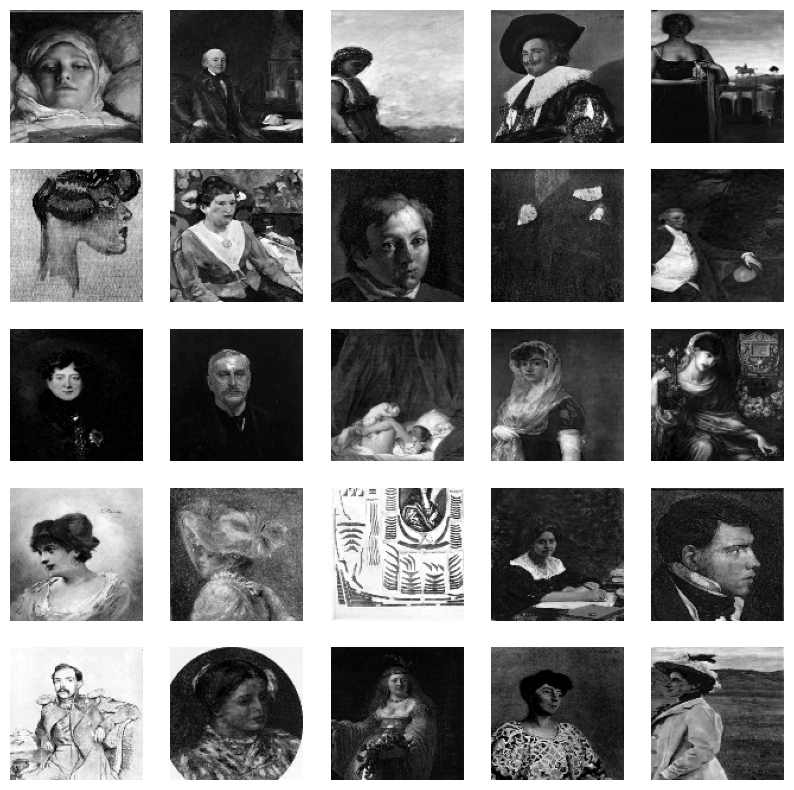

In [22]:
show_batch(image_batch)

This code shows a bunch of grayscale images from our training set. We use Matplotlib to set up a grid for displaying these images. Then, we iterate through the first 25 images in our batch and plot each one in a subplot without any extra labels or ticks. The image_batch variable holds a bunch of images, each sized 112x112 pixels.

### Making the GANS Architecture 

In [23]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

1. EPOCHS = 200: Specifies the number of training epochs, determining how many times the entire dataset will be passed through the model during training.

2. noise_dim = 100: Defines the dimensionality of the noise vector used as input to the generator model. This noise is sampled from a normal distribution and serves as input for generating images.

3. num_examples_to_generate = 16: Determines the number of images to generate at once during training or inference.

4. seed = tf.random.normal([num_examples_to_generate, noise_dim]): Initializes a random seed consisting of num_examples_to_generate noise vectors, each with a dimensionality of noise_dim. These noise vectors serve as input to the generator model for generating images.

In [24]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*1024, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 1024)))
    assert model.output_shape == (None, 7, 7, 1024) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 56, 56, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 112, 112, 1)

    return model

1. model = tf.keras.Sequential(): Initializes a sequential model.

2. model.add(layers.Dense(7*7*1024, use_bias=False, input_shape=(noise_dim,))): Adds a fully connected layer with 7x7x1024 units, using the input noise

3. vector dimensionality noise_dim. This layer acts as the initial dense layer of the generator.

4. model.add(layers.BatchNormalization()): Applies batch normalization to the output of the dense layer to improve training stability.

5. model.add(layers.LeakyReLU()): Applies Leaky ReLU activation function to introduce non-linearity.

6. model.add(layers.Reshape((7, 7, 1024))): Reshapes the output into a 7x7x1024 tensor, preparing it for the convolutional layers.

7. model.add(layers.Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', use_bias=False)): Adds a transposed convolutional layer with 512 filters, 5x5 kernel size, and stride 1x1 to upsample the spatial dimensions.

8. assert model.output_shape == (None, 7, 7, 512): Asserts that the output shape matches the expected shape.

9. The subsequent layers follow a similar pattern of transposed convolutional layers with decreasing filter sizes and increasing spatial dimensions until the desired output shape of (112, 112, 1) is achieved.

#### Generating an Image without training

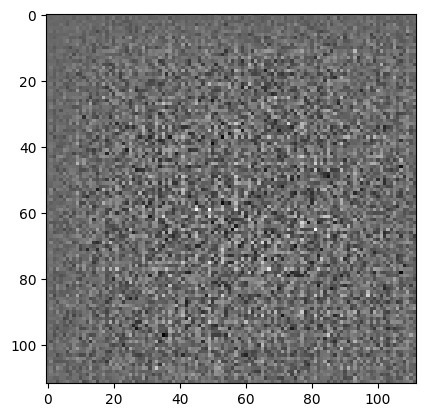

In [25]:
generator = make_generator_model()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

We can see that without training our generator model has just generated a picture without anything. After training it along with the discriminator model, our generator would start to produce more reasonable images.

##### Summary of the Generator Model

In [26]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50176)             5017600   
                                                                 
 batch_normalization (BatchN  (None, 50176)            200704    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50176)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 512)        13107200  
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 512)        2

Layer Composition: The model is composed of several layers including Dense, BatchNormalization, LeakyReLU, Reshape, and Conv2DTranspose layers.

Output Shape: The output shapes of each layer are specified, providing insight into the tensor dimensions at each stage of the model.

Parameters: The number of parameters for each layer is listed, representing the weights and biases that are learned during training.

Total Parameters: The total number of trainable parameters in the model is calculated, indicating the complexity of the model and its capacity to learn from data.

Trainable vs Non-trainable Parameters: The trainable parameters are those that will be updated during training to minimize the loss function, while non-trainable parameters typically represent fixed components such as batch normalization statistics.

In [28]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[112, 112, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Sequential Model: The discriminator is constructed as a sequential model using TensorFlow's Keras API, allowing layers to be added sequentially.

Convolutional Layers: The model starts with a series of convolutional layers, each followed by a LeakyReLU activation function to introduce non-
linearity. These layers are designed to extract features from the input images.

Dropout Layers: Dropout layers are included after each convolutional layer to regularize the model and prevent overfitting by randomly dropping a fraction of input units during training.

Flatten Layer: After the convolutional layers, a flatten layer is added to flatten the output from the convolutional layers into a 1D tensor, preparing it for the final classification layer.

Dense Layer: Finally, a dense layer with a single neuron is added, which outputs a single scalar value indicating the likelihood that the input image is real (as opposed to generated). No activation function is specified for this layer, as the output will be treated as raw logits.

##### Testing our Discriminator Model on the generated image

In [29]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[2.8537292e-05]], shape=(1, 1), dtype=float32)


The decision made by the discriminator model. In this case, the output is a TensorFlow tensor containing a single scalar value, approximately 2.8537292e-05, indicating a very low confidence that the generated image is real.

#### Adding the Loss Functions and Parameter Optimizers

In [30]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [31]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [32]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

1. Binary Crossentropy Loss: The cross_entropy variable is initialized with the BinaryCrossentropy loss function from TensorFlow's Keras API. This loss function is suitable for binary classification tasks, where the model predicts probabilities for two classes (real or fake). Setting from_logits=True indicates that the model's output is not normalized and should be treated as logits.

2. Discriminator Loss Function: The discriminator_loss function calculates the total loss for the discriminator based on its predictions for real and fake images. It computes the binary crossentropy loss for both real and fake outputs, comparing them to the respective target labels (1 for real and 0 for fake), and returns their sum as the total loss.

3. Generator Loss Function: The generator_loss function calculates the loss for the generator based on its generated fake outputs. It computes the binary crossentropy loss between the discriminator's predictions for the fake outputs and the target label of 1, indicating that the generator aims to fool the discriminator into believing its outputs are real.

4. Optimizer Initialization: Two Adam optimizers are initialized for the generator and discriminator models, respectively, with learning rate of 1e-4. Adam is a popular optimization algorithm that adapts the learning rate for each parameter during training, making it suitable for training deep neural networks like GANs.

#### Saving the CheckPoints

In [64]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### Creating the Custom Training Loop

We are building a custom training loop, as gans are somewhat different from the traditioinal neural networks. In this arch, both generator and discriminator are trained and tested together.

The Benefits of the Custom Training Loop are: 

1. Dual Optimization: GANs consist of two neural networks, the generator and the discriminator, which are trained simultaneously in a competitive manner. Each network has its own loss function and optimizer, and their training steps are interleaved. A custom training loop allows for fine-grained control over these training steps, ensuring that both networks are updated appropriately.

2. Gradient Flow Control: GAN training can be challenging due to issues such as mode collapse and instability. Custom training loops provide flexibility in how gradients are computed and applied, allowing for techniques like gradient clipping and different learning rate schedules to stabilize training and prevent mode collapse.

3. Dynamic Learning Rate Scheduling: GANs often benefit from dynamic learning rate scheduling, where the learning rates of the generator and discriminator are adjusted during training based on the convergence of the networks. Custom training loops enable the implementation of such dynamic learning rate schedules tailored to the specific needs of GAN training.

In [39]:
gen_losses = []
disc_losses = []

In [50]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        print("Generator Loss: ", gen_loss)
        print("Discriminator Loss: ", disc_loss)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

1. Noise Generation: Random noise vectors are generated using tf.random.normal() with a shape of [BATCH_SIZE, noise_dim], where BATCH_SIZE is the batch size and noise_dim is the dimensionality of the noise vectors.

2. Forward Pass: Inside a gradient tape context (tf.GradientTape()), the generator is called with the generated noise to produce fake images. Both the real and fake images are then passed through the discriminator to obtain their respective outputs.

3. Loss Computation: The generator loss (gen_loss) and discriminator loss (disc_loss) are computed based on the outputs of the discriminator. The generator aims to minimize the discrepancy between the fake outputs and real labels, while the discriminator aims to correctly classify real and fake images.

4. Gradient Calculation: The gradient tapes record the gradients of the generator and discriminator losses with respect to their trainable variables.

5. Gradient Application: The gradients are applied to the generator and discriminator using their respective optimizers (generator_optimizer and discriminator_optimizer) via the apply_gradients method.

In [51]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [52]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

This function orchestrates the training process for the GAN, ensuring that both the generator and discriminator are trained iteratively over multiple epochs while periodically generating images for visualization and monitoring purposes.

#### Starting the Training Of the Model

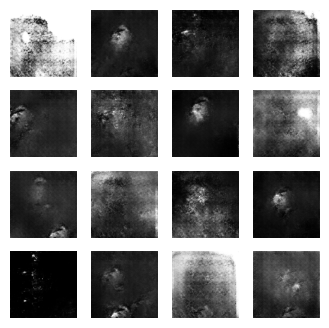

Time for epoch 640 is 37.47936797142029 sec


KeyboardInterrupt: 

In [53]:
train(train_ds, EPOCHS)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)